<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/PySpark-Analytics-Hub/blob/main/Regression_with_an_Insurance_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviroment

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions list

ref                                                                                deadline             category                reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2      2025-04-01 23:59:00  Featured         2,117,152 Usd        988           False  
https://www.kaggle.com/competitions/konwinski-prize                                2025-03-12 23:59:00  Featured         1,225,000 Usd        160           False  
https://www.kaggle.com/competitions/gemma-language-tuning                          2025-01-15 00:59:00  Analytics          150,000 Usd          0           False  
https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting  2025-01-13 23:59:00  Featured           120,000 Usd       3662           False  
https://www.kagg

In [3]:
%%bash
kaggle competitions download -c playground-series-s4e12
unzip /content/playground-series-s4e12.zip


Archive:  /content/playground-series-s4e12.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


100%|██████████| 75.5M/75.5M [00:00<00:00, 247MB/s]


# Import Libraries

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f

import pandas as pd
import matplotlib.pyplot as plt

# Setup Session

In [7]:
spark = SparkSession.builder.appName("Insurance-Analysis").getOrCreate()

In [8]:
# Pandas setting
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 150

# Load Dataset

In [21]:
train_df = spark.read.csv(
    path="/content/train.csv",
    sep=",",
    header=True,
    inferSchema=True
).cache()

test_df = spark.read.csv(
    path="/content/test.csv",
    sep=",",
    header=True,
    inferSchema=True
).cache()

In [22]:
train_df.show(5)

+---+----+------+-------------+--------------+--------------------+---------------+-------------+------------------+--------+-------------+---------------+-----------+------------+------------------+--------------------+-----------------+--------------+------------------+-------------+--------------+
| id| Age|Gender|Annual Income|Marital Status|Number of Dependents|Education Level|   Occupation|      Health Score|Location|  Policy Type|Previous Claims|Vehicle Age|Credit Score|Insurance Duration|   Policy Start Date|Customer Feedback|Smoking Status|Exercise Frequency|Property Type|Premium Amount|
+---+----+------+-------------+--------------+--------------------+---------------+-------------+------------------+--------+-------------+---------------+-----------+------------+------------------+--------------------+-----------------+--------------+------------------+-------------+--------------+
|  0|19.0|Female|      10049.0|       Married|                 1.0|     Bachelor's|Self-Employ

In [23]:
test_df.show(5)

+-------+----+------+-------------+--------------+--------------------+---------------+-------------+------------------+--------+-------------+---------------+-----------+------------+------------------+--------------------+-----------------+--------------+------------------+-------------+
|     id| Age|Gender|Annual Income|Marital Status|Number of Dependents|Education Level|   Occupation|      Health Score|Location|  Policy Type|Previous Claims|Vehicle Age|Credit Score|Insurance Duration|   Policy Start Date|Customer Feedback|Smoking Status|Exercise Frequency|Property Type|
+-------+----+------+-------------+--------------+--------------------+---------------+-------------+------------------+--------+-------------+---------------+-----------+------------+------------------+--------------------+-----------------+--------------+------------------+-------------+
|1200000|28.0|Female|       2310.0|          NULL|                 4.0|     Bachelor's|Self-Employed| 7.657980871690055|   Rura

## Concatenate Train/Test

In [74]:
df_temp = train_df.unionByName(test_df, allowMissingColumns=True)
df_temp.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Annual Income: double (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Number of Dependents: double (nullable = true)
 |-- Education Level: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Health Score: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Policy Type: string (nullable = true)
 |-- Previous Claims: double (nullable = true)
 |-- Vehicle Age: double (nullable = true)
 |-- Credit Score: double (nullable = true)
 |-- Insurance Duration: double (nullable = true)
 |-- Policy Start Date: timestamp (nullable = true)
 |-- Customer Feedback: string (nullable = true)
 |-- Smoking Status: string (nullable = true)
 |-- Exercise Frequency: string (nullable = true)
 |-- Property Type: string (nullable = true)
 |-- Premium Amount: double (nullable = true)



In [75]:
# Check shape of dataframe
df_temp.count(), len(df_temp.columns)

(2000000, 21)

# Analyzing

### Missng Values

In [59]:
def check_missing_values(df):
    print("Columns with Missing Values: \n")
    for col in df.columns:
        nans = df.filter(f.col(col).isNull()).count()
        if nans > 0:
            print(f"{col}: {nans}")

# use func to check missing values
check_missing_values(df_temp)

Columns with Missing Values: 

Age: 31194
Annual Income: 74809
Marital Status: 30865
Number of Dependents: 182802
Occupation: 597200
Health Score: 123525
Previous Claims: 606831
Vehicle Age: 9
Credit Score: 229333
Insurance Duration: 3
Customer Feedback: 130100
Premium Amount: 800000


### Statistical Summary

In [60]:
df_temp.summary().show()

+-------+-----------------+------------------+-------+------------------+--------------+--------------------+---------------+----------+------------------+--------+-----------+------------------+-----------------+------------------+------------------+-----------------+--------------+------------------+-------------+------------------+
|summary|               id|               Age| Gender|     Annual Income|Marital Status|Number of Dependents|Education Level|Occupation|      Health Score|Location|Policy Type|   Previous Claims|      Vehicle Age|      Credit Score|Insurance Duration|Customer Feedback|Smoking Status|Exercise Frequency|Property Type|    Premium Amount|
+-------+-----------------+------------------+-------+------------------+--------------+--------------------+---------------+----------+------------------+--------+-----------+------------------+-----------------+------------------+------------------+-----------------+--------------+------------------+-------------+---------

# Preprocessing

### Correct Columns Name

In [76]:
df_temp = (
    df_temp
    .withColumnRenamed("Annual Income", "Annual_Income")
    .withColumnRenamed("Marital Status", "Marital_Status")
    .withColumnRenamed("Number of Dependents", "Number_of_Dependents")
    .withColumnRenamed("Education Level", "Education_Level")
    .withColumnRenamed("Health Score", "Health_Score")
    .withColumnRenamed("Policy Type", "Policy_Type")
    .withColumnRenamed("Previous Claims", "Previous_Claims")
    .withColumnRenamed("Vehicle Age", "Vehicle_Age")
    .withColumnRenamed("Credit Score", "Credit_Score")
    .withColumnRenamed("Insurance Duration", "Insurance_Duration")
    .withColumnRenamed("Customer Feedback", "Customer_Feedback")
    .withColumnRenamed("Smoking Status", "Smoking_Status")
    .withColumnRenamed("Exercise Frequency", "Exercise_Frequency")
    .withColumnRenamed("Property Type", "Property_Type")
    .withColumnRenamed("Premium Amount", "Premium_Amount")
)

In [77]:
df_temp.show(1)

+---+----+------+-------------+--------------+--------------------+---------------+-------------+-----------------+--------+-----------+---------------+-----------+------------+------------------+--------------------+-----------------+--------------+------------------+-------------+--------------+
| id| Age|Gender|Annual_Income|Marital_Status|Number_of_Dependents|Education_Level|   Occupation|     Health_Score|Location|Policy_Type|Previous_Claims|Vehicle_Age|Credit_Score|Insurance_Duration|   Policy Start Date|Customer_Feedback|Smoking_Status|Exercise_Frequency|Property_Type|Premium_Amount|
+---+----+------+-------------+--------------+--------------------+---------------+-------------+-----------------+--------+-----------+---------------+-----------+------------+------------------+--------------------+-----------------+--------------+------------------+-------------+--------------+
|  0|19.0|Female|      10049.0|       Married|                 1.0|     Bachelor's|Self-Employed|22.598

### Correct Datatypes

In [78]:
df_temp.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Number_of_Dependents: double (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Health_Score: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Policy_Type: string (nullable = true)
 |-- Previous_Claims: double (nullable = true)
 |-- Vehicle_Age: double (nullable = true)
 |-- Credit_Score: double (nullable = true)
 |-- Insurance_Duration: double (nullable = true)
 |-- Policy Start Date: timestamp (nullable = true)
 |-- Customer_Feedback: string (nullable = true)
 |-- Smoking_Status: string (nullable = true)
 |-- Exercise_Frequency: string (nullable = true)
 |-- Property_Type: string (nullable = true)
 |-- Premium_Amount: double (nullable = true)



In [79]:
df_temp = (
    df_temp
    .withColumn("Age", f.col("Age").cast(IntegerType()))
    .withColumn("Number_of_Dependents", f.col("Number_of_Dependents").cast(IntegerType()))
    .withColumn("Vehicle_Age", f.col("Vehicle_Age").cast(IntegerType()))
    .withColumn("Insurance_Duration", f.col("Insurance_Duration").cast(IntegerType()))
    .withColumn("Premium_Amount", f.col("Premium_Amount").cast(IntegerType()))
    .withColumn("Credit_Score", f.col("Credit_Score").cast(IntegerType()))
)

### Handling Missing Values

In [80]:
from pyspark.ml.feature import Imputer

In [81]:
# Numerical Variables
numerical_cols = ['Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
                  'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration']

numeric_imputer = Imputer(
    inputCols=numerical_cols,
    outputCols=[col + "_imputed" for col in numerical_cols],
    strategy="mean"
)

# Apply Imputer
imputer_model = numeric_imputer.fit(df_temp)
df_temp = imputer_model.transform(df_temp)

In [82]:
df_temp.count(), len(df_temp.columns)

(2000000, 29)

In [83]:
check_missing_values(df_temp)

Columns with Missing Values: 

Age: 31194
Annual_Income: 74809
Marital_Status: 30865
Number_of_Dependents: 182802
Occupation: 597200
Health_Score: 123525
Previous_Claims: 606831
Vehicle_Age: 9
Credit_Score: 229333
Insurance_Duration: 3
Customer_Feedback: 130100
Premium_Amount: 800000


In [84]:
# Drop columns with Nans
df_temp = df_temp.drop(*numerical_cols)
df_temp.show(1)

+---+------+--------------+---------------+-------------+--------+-----------+--------------------+-----------------+--------------+------------------+-------------+--------------+-----------+---------------------+----------------------------+--------------------+-----------------------+-------------------+--------------------+--------------------------+
| id|Gender|Marital_Status|Education_Level|   Occupation|Location|Policy_Type|   Policy Start Date|Customer_Feedback|Smoking_Status|Exercise_Frequency|Property_Type|Premium_Amount|Age_imputed|Annual_Income_imputed|Number_of_Dependents_imputed|Health_Score_imputed|Previous_Claims_imputed|Vehicle_Age_imputed|Credit_Score_imputed|Insurance_Duration_imputed|
+---+------+--------------+---------------+-------------+--------+-----------+--------------------+-----------------+--------------+------------------+-------------+--------------+-----------+---------------------+----------------------------+--------------------+----------------------

In [88]:
# Categorical Features Imputation
categorical_cols = ['Gender', 'Marital_Status', 'Education_Level', 'Occupation',
                    'Location', 'Policy_Type', 'Customer_Feedback', 'Smoking_Status',
                    'Exercise_Frequency', 'Property_Type']

for col_name in categorical_cols:
    # Calculate mode
    mode_value = df_temp.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]
    # Replace null with mode
    df_temp = df_temp.withColumn(
        col_name,
        f.when(f.col(col_name).isNull(), mode_value).otherwise(f.col(col_name))
    )

Male
Single
Master's
None
Suburban
Premium
Average
Yes
Weekly
House


In [91]:
# Calculate mode for Occupation
mode_value = (
    df_temp.filter(f.col("Occupation").isNotNull())
    .groupBy("Occupation")
    .count()
    .orderBy("count", ascending=False)
    .first()
)

if mode_value:
    mode_value = mode_value[0]  # Extract the mode value
else:
    mode_value = "Unknown"  # Fallback if no non-null mode is found

# Replace null with mode or fallback value
df_temp = df_temp.withColumn(
    "Occupation",
    f.when(f.col("Occupation").isNull(), mode_value).otherwise(f.col("Occupation"))
)

Row(Occupation='Employed', count=471324)

In [94]:
check_missing_values(df_temp)

Columns with Missing Values: 

Premium_Amount: 800000


# Analyzing #2

In [110]:
# Analyze by Gender
df_temp.groupBy("Gender").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+------+-------+-----------------+---------------------+----------------------+
|Gender|  Count|      Average_Age|Average_Annual_Income|Average_Premium_Amount|
+------+-------+-----------------+---------------------+----------------------+
|Female| 996340|41.14100307124074|    32775.15847674906|     1102.404973645404|
|  Male|1003660|41.13840742881055|    32762.25114838088|    1102.6834763040372|
+------+-------+-----------------+---------------------+----------------------+



In [111]:
# Analyze by Occupation
df_temp.groupBy("Occupation").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+-------------+-------+-----------------+---------------------+----------------------+
|   Occupation|  Count|      Average_Age|Average_Annual_Income|Average_Premium_Amount|
+-------------+-------+-----------------+---------------------+----------------------+
|     Employed|1068524| 41.1112721848082|   32653.369368613214|     1099.533428002965|
|Self-Employed| 470636|41.19376120823736|   32881.448761510204|    1106.6092837304745|
|   Unemployed| 460840| 41.1504057807482|    32920.88363369831|      1105.36902325245|
+-------------+-------+-----------------+---------------------+----------------------+



In [112]:
# Analyze by Martial Status
df_temp.groupBy("Marital_Status").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+--------------+------+-----------------+---------------------+----------------------+
|Marital_Status| Count|      Average_Age|Average_Annual_Income|Average_Premium_Amount|
+--------------+------+-----------------+---------------------+----------------------+
|       Married|656488|41.16945321163524|   32613.462131647848|    1099.8443887643414|
|      Divorced|653551|41.13359171663726|   32684.380546497734|    1100.6251161413504|
|        Single|689961|41.11717763757662|    32996.22191091367|    1106.9343061461152|
+--------------+------+-----------------+---------------------+----------------------+



In [113]:
# Analyze by Education_Level
df_temp.groupBy("Education_Level").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+---------------+------+------------------+---------------------+----------------------+
|Education_Level| Count|       Average_Age|Average_Annual_Income|Average_Premium_Amount|
+---------------+------+------------------+---------------------+----------------------+
|    High School|482198| 41.15173434978992|    32869.74873469976|     1104.787490369367|
|            PhD|505975| 41.11293245713721|    32687.07296978747|    1100.6838853799088|
|     Bachelor's|505457|41.138534039492974|   32747.856090542056|    1102.6984375103057|
|       Master's|506370|41.156152615676284|    32774.77031040215|    1102.1139892962235|
+---------------+------+------------------+---------------------+----------------------+



In [114]:
# Analyze by Education_Level
df_temp.groupBy("Policy_Type").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+-------------+------+------------------+---------------------+----------------------+
|  Policy_Type| Count|       Average_Age|Average_Annual_Income|Average_Premium_Amount|
+-------------+------+------------------+---------------------+----------------------+
|      Premium|669475|41.134986369916724|    32736.38572240153|    1101.5792766383142|
|Comprehensive|665822|41.153905998900605|     32753.8086593814|    1102.6105255255254|
|        Basic|664703| 41.13021906024194|   32816.106085860614|     1103.452465663373|
+-------------+------+------------------+---------------------+----------------------+



In [115]:
# Analyze by Policy_Type
df_temp.groupBy("Policy_Type").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+-------------+------+------------------+---------------------+----------------------+
|  Policy_Type| Count|       Average_Age|Average_Annual_Income|Average_Premium_Amount|
+-------------+------+------------------+---------------------+----------------------+
|      Premium|669475|41.134986369916724|    32736.38572240153|    1101.5792766383142|
|Comprehensive|665822|41.153905998900605|     32753.8086593814|    1102.6105255255254|
|        Basic|664703| 41.13021906024194|   32816.106085860614|     1103.452465663373|
+-------------+------+------------------+---------------------+----------------------+



In [116]:
# Analyze by Policy_Type
df_temp.groupBy("Customer_Feedback").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+-----------------+------+------------------+---------------------+----------------------+
|Customer_Feedback| Count|       Average_Age|Average_Annual_Income|Average_Premium_Amount|
+-----------------+------+------------------+---------------------+----------------------+
|          Average|759222|41.130163509487346|   33445.834290138926|    1110.6198113352452|
|             Good|614826| 41.16187832004502|   32420.352917212054|    1096.2842987040106|
|             Poor|625952|41.129484369408516|    32289.49389121861|    1098.8927454875666|
+-----------------+------+------------------+---------------------+----------------------+



In [117]:
# Analyze by Smoking_Status
df_temp.groupBy("Smoking_Status").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+--------------+-------+-----------------+---------------------+----------------------+
|Smoking_Status|  Count|      Average_Age|Average_Annual_Income|Average_Premium_Amount|
+--------------+-------+-----------------+---------------------+----------------------+
|            No| 996268|41.13855207634894|     32800.9047042477|     1102.403606591911|
|           Yes|1003732|41.14084038368808|   32736.697302085275|       1102.6851578323|
+--------------+-------+-----------------+---------------------+----------------------+



In [118]:
# Analyze by Property_Type
df_temp.groupBy("Property_Type").agg(
    f.count("*").alias("Count"),
    f.avg("Age_imputed").alias("Average_Age"),
    f.avg("Annual_Income_imputed").alias("Average_Annual_Income"),
    f.avg("Premium_Amount").alias("Average_Premium_Amount")
).show()

+-------------+------+------------------+---------------------+----------------------+
|Property_Type| Count|       Average_Age|Average_Annual_Income|Average_Premium_Amount|
+-------------+------+------------------+---------------------+----------------------+
|    Apartment|666022|41.153158604370425|    32776.72121014881|     1104.150595782768|
|        Condo|666478|41.137719474611316|    32822.96747376813|     1101.922626747366|
|        House|667500| 41.12825018726592|   32706.455811975222|    1101.5616799342574|
+-------------+------+------------------+---------------------+----------------------+



In [131]:
def hist_plot(df, col_name):
    # Sample a fraction of the data
    sample_df = df_temp.sample(fraction=0.1, seed=42)
    # Convert to pandas dataframe
    pandas_df = sample_df.toPandas()
    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(pandas_df[col_name], bins='auto')
    plt.xlabel(f"{col_name}", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(f"Distribution of {col_name}", fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.show()

In [132]:
# Select numeric values
from pyspark.sql.types import NumericType
numeric_cols = [field.name for field in df_temp.schema.fields if isinstance(field.dataType ,NumericType)]
numeric_cols

['id',
 'Premium_Amount',
 'Age_imputed',
 'Annual_Income_imputed',
 'Number_of_Dependents_imputed',
 'Health_Score_imputed',
 'Previous_Claims_imputed',
 'Vehicle_Age_imputed',
 'Credit_Score_imputed',
 'Insurance_Duration_imputed']

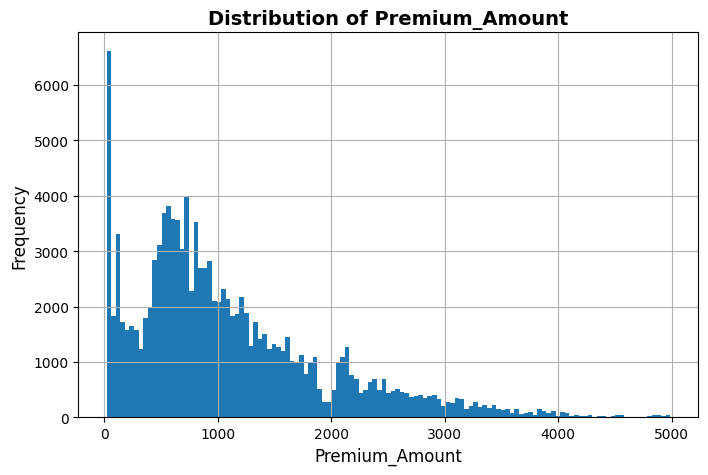

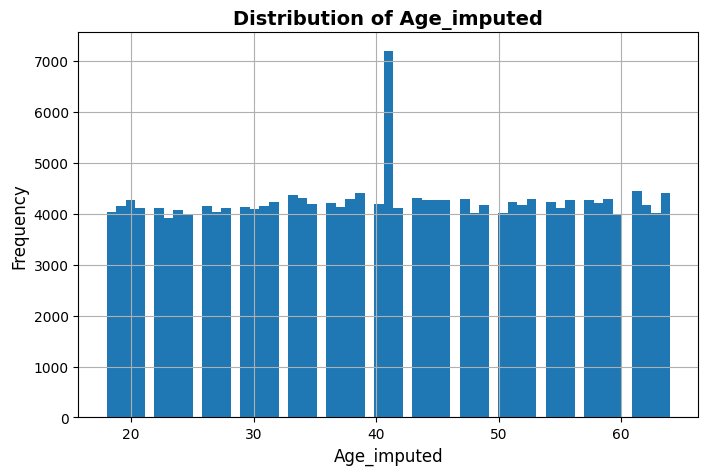

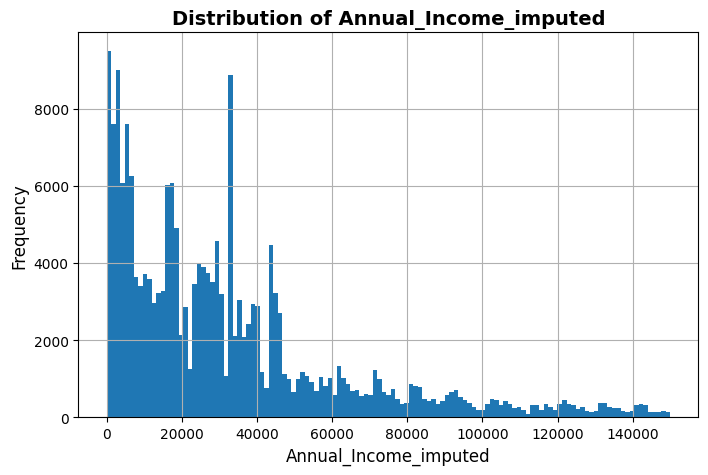

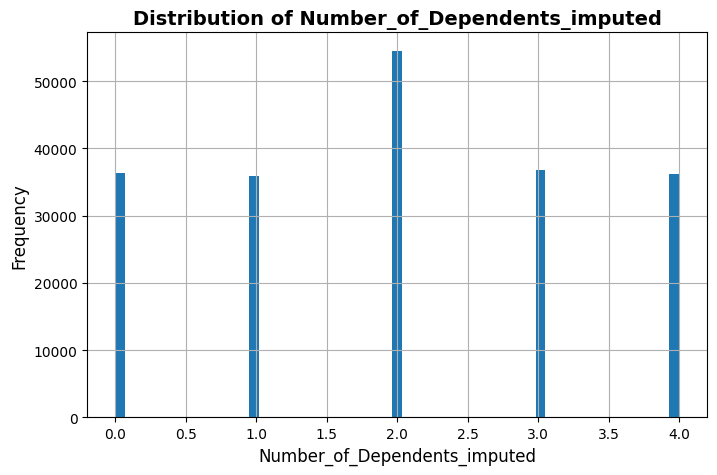

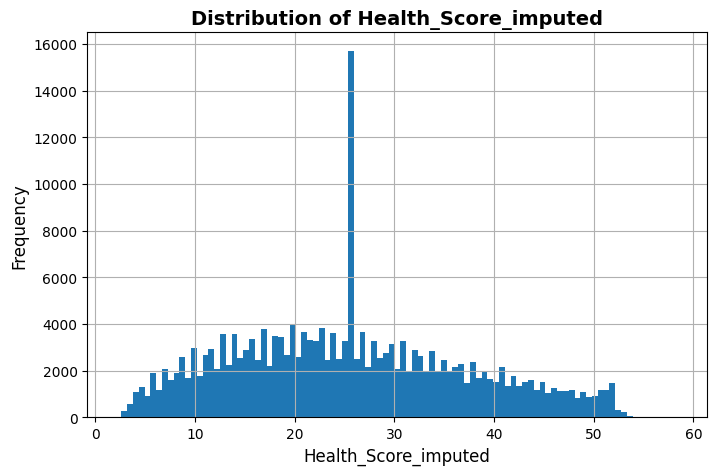

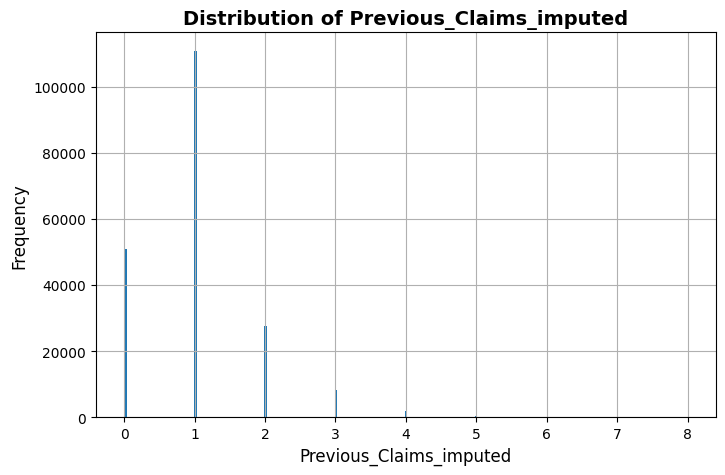

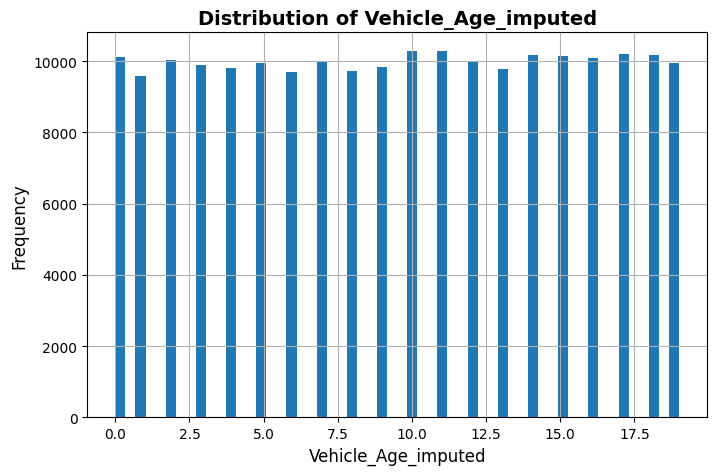

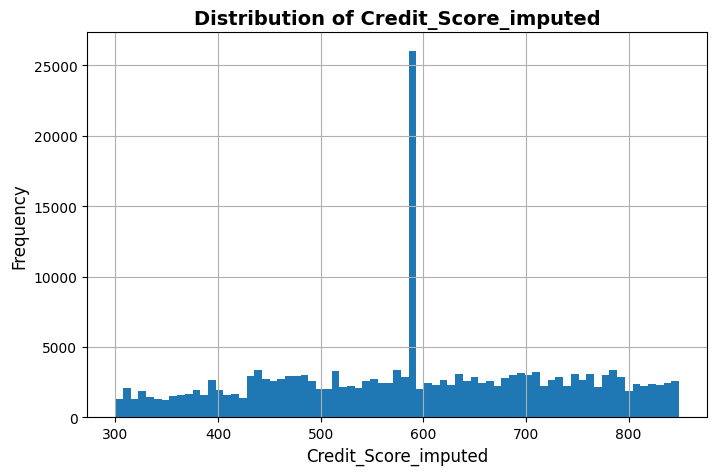

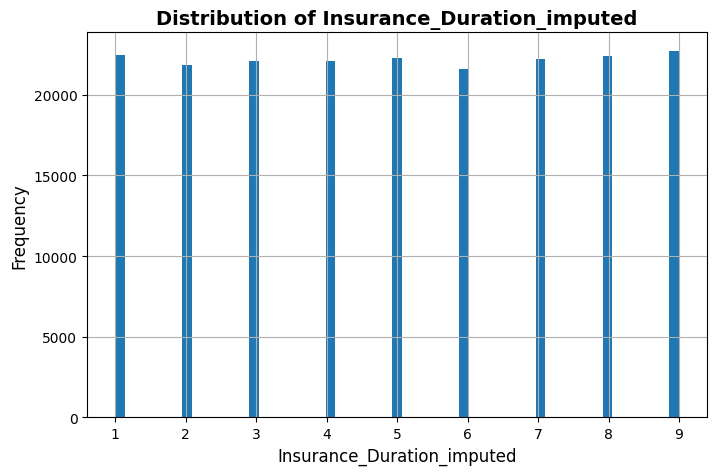

In [133]:
for col in numeric_cols[1:]:
    hist_plot(df_temp, col)
    print("")